# Application of Machine Learning to Predicting Matches in Speed Dating

### Introduction

Recent speed dating events have not been particularly successful, with many participants leaving without a match. Participants frequently mention that they spend most of the evening talking to people that they don't feel any connection with, and as a result leave feeling dissatisfied with the event. This customer dissatisfaction has led to poor reviews and fewer word of mouth recommendations, which is impacting the business's reputation, demand and ultimately revenue.

A potential solution to this problem would be to pair participants up with partners that they are more likely to match with. This could be done for example by taking details from a large pool of participants, identifying their likely matches, and then assigning them to smaller speed dating events where the participants are selected based on their compatibility. The advantage of this approach is that participants will spend less time talking to people that they don't feel a connection with, and are more likely to leave the event with a match.

The aim of this project is to investigate what factors affect the likelihood of a match, and to use supervised machine learning techniques to develop a predictive model that aims to predict whether or not two participants will be a match before they’ve met. This model can then be used to pair up participants with their likely matches, thereby increasing customer satisfaction, business reputation and revenue.

### The Dataset

The dataset used in this project can be found on DataCamp's GitHub account (https://github.com/datacamp/careerhub-data/tree/master/Speed%20Dating), as well as details of the column names and their descriptions.

### Analysis Plan

The plan for the project is as follows:

- Import and clean the data, readying it for investigation
- Perform exploratory data analysis to extract relevant insights
- Select appropriate performance metrics for use in evaluating a machine learning model for predicting matches
- Identify and fine-tune a suitable model to maximise its predictive power
- Evaluate the results to determine if the model is ready for use or if further work is required

### Importing and Cleaning the Data

In [184]:
# Import pandas and read in the data
import pandas as pd
dating = pd.read_csv('https://raw.githubusercontent.com/datacamp/careerhub-data/master/Speed%20Dating/speed_dating.csv', na_values='?')
dating.head()

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,0,1,female,21.0,27.0,6,[4-6],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],7.0,6.0,[6-8],[5-6],0.0,1,0,0
1,0,1,female,21.0,22.0,1,[0-1],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],7.0,5.0,[6-8],[5-6],1.0,1,0,0
2,1,1,female,21.0,22.0,1,[0-1],'Asian/Pacific Islander/Asian-American','Asian/Pacific Islander/Asian-American',1,...,[0-3],[3-5],7.0,NaN,[6-8],[0-4],1.0,1,1,1
3,0,1,female,21.0,23.0,2,[2-3],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,...,[0-3],[3-5],7.0,6.0,[6-8],[5-6],0.0,1,1,1
4,0,1,female,21.0,24.0,3,[2-3],'Asian/Pacific Islander/Asian-American','Latino/Hispanic American',0,...,[0-3],[3-5],6.0,6.0,[6-8],[5-6],0.0,1,1,1


Each row contains information about the person who is going on a date, including age, race, interests, self-ratings on various qualities, and ratings of the importance of said qualities in a partner. From now on we will refer to this individual as Person A.<br>
Additionally there is some information about the other party to the date, though this data is much more limited; for example we have no information on their interests of self-ratings. We will refer to this individual as Person B.

In [185]:
# View column names
with pd.option_context('display.max_seq_items', None):
    print (dating.columns)

Index(['has_null', 'wave', 'gender', 'age', 'age_o', 'd_age', 'd_d_age',
       'race', 'race_o', 'samerace', 'importance_same_race',
       'importance_same_religion', 'd_importance_same_race',
       'd_importance_same_religion', 'field', 'pref_o_attractive',
       'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny',
       'pref_o_ambitious', 'pref_o_shared_interests', 'd_pref_o_attractive',
       'd_pref_o_sincere', 'd_pref_o_intelligence', 'd_pref_o_funny',
       'd_pref_o_ambitious', 'd_pref_o_shared_interests', 'attractive_o',
       'sinsere_o', 'intelligence_o', 'funny_o', 'ambitous_o',
       'shared_interests_o', 'd_attractive_o', 'd_sinsere_o',
       'd_intelligence_o', 'd_funny_o', 'd_ambitous_o', 'd_shared_interests_o',
       'attractive_important', 'sincere_important', 'intellicence_important',
       'funny_important', 'ambtition_important', 'shared_interests_important',
       'd_attractive_important', 'd_sincere_important',
       'd_intellicence_important', 

There are a lot of variables in the dataset that can only be obtained after the date, such as 'sincere_o' (sincerity rating of Person A by Person B) and 'attractivepartner' (attractiveness rating of Person B by Person A). We will drop these variables because we are only interested in predicting matches based on information we can obtain ahead of the date.<br>
Additionally there are a number of variables beginning with d_. Aside from d_age, which is the age difference between the individuals, these columns simply group other columns into broad buckets. We will drop these variables too as they don't add any new information to the dataset.<br>
Finally we will drop any further columns that are unlikely to contribute to the model; in particular 'has_null', 'field' and 'wave'.

In [186]:
# Drop columns we don't need

# Drop bucketed columns (i.e. those that group a numeric answer into a bucket, e.g. [2-5])
bucketed = [c for c in dating.columns if c[:2] == 'd_'] # create a list of all columns beginning with d_
bucketed.remove('d_age') # the column d_age is an exception as d stands for difference here; it is not a bucketed column
dating = dating.drop(columns=bucketed) # drop said bucketed columns

# Drop information that can only be obtained after the date
on_the_day = ['attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o', 'ambitous_o', 'shared_interests_o',
          'attractive_partner', 'sincere_partner', 'intelligence_partner', 'funny_partner', 'ambition_partner', 'shared_interests_partner',
          'like', 'guess_prob_liked', 'met']
dating = dating.drop(columns=on_the_day)

# Drop other columns that are unlikely to contribute to the model or have no description
unnecessary = ['has_null', 'field', 'wave']
dating = dating.drop(columns=unnecessary)

# Check remaining columns
dating.columns

Index(['gender', 'age', 'age_o', 'd_age', 'race', 'race_o', 'samerace',
       'importance_same_race', 'importance_same_religion', 'pref_o_attractive',
       'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny',
       'pref_o_ambitious', 'pref_o_shared_interests', 'attractive_important',
       'sincere_important', 'intellicence_important', 'funny_important',
       'ambtition_important', 'shared_interests_important', 'attractive',
       'sincere', 'intelligence', 'funny', 'ambition', 'sports', 'tvsports',
       'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing',
       'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping',
       'yoga', 'interests_correlate', 'expected_happy_with_sd_people',
       'expected_num_interested_in_me', 'expected_num_matches', 'decision',
       'decision_o', 'match'],
      dtype='object')

In [187]:
# Count the number of missing values in each column
dating.isnull().sum()

gender                              0
age                                95
age_o                             104
d_age                               0
race                               63
race_o                             73
samerace                            0
importance_same_race               79
importance_same_religion           79
pref_o_attractive                  89
pref_o_sincere                     89
pref_o_intelligence                89
pref_o_funny                       98
pref_o_ambitious                  107
pref_o_shared_interests           129
attractive_important               79
sincere_important                  79
intellicence_important             79
funny_important                    89
ambtition_important                99
shared_interests_important        121
attractive                        105
sincere                           105
intelligence                      105
funny                             105
ambition                          105
sports      

We can see that there are missing values in most of the columns. In particular two columns have over 1,000 missing values; 'expected_num_interested_in_me' and 'expected_num_matches'. Given the large proportion of missing values in these columns, it seems sensible to drop them, rather than to guess what the values should be and potentially bias the predictive model.
Across the remaining columns, we can see that many columns have exactly the same number of missing values. This implies that they perhaps relate to the same individuals; for example, perhaps most individuals gave a rating for all of the interests specified, but a few did not give any ratings. If this is the case, and the proportion of said rows are small, we may be able to drop these rows entirely in order to eliminate the missing values.

In [188]:
# Two of the columns have a significant number of missing values so we will drop them.
dating = dating.drop(columns=['expected_num_interested_in_me', 'expected_num_matches'])

In [189]:
# Count the number of missing values in each row
missing_per_row = dating.isnull().sum(axis=1)

# Calculate rows with missing values as a proportion of the total number of rows
proportion = len(missing_per_row[missing_per_row>0])/len(missing_per_row)
print(round(proportion*100,2),"%")

3.8 %


We can see that the missing values occur in only 3.8% of the population. Given this is so small, it makes sense to drop these rows, rather than to try and impute the missing values based on an uninformed best guess.

In [190]:
# Drop rows with missing values
dating['num_missing'] = missing_per_row # add column showing number of missing values
dating = dating[dating['num_missing']==0] # filter to only include rows with no missing values
dating = dating.drop(columns=['num_missing']) # drop new num_missing column
dating.isnull().sum().sum() # check remaining missing values

0

This confirms that there are no longer any missing values in the dataset.<br>
Next we want to ensure that the columns have the right data types.

In [191]:
# Check data types
dating.dtypes

gender                            object
age                              float64
age_o                            float64
d_age                              int64
race                              object
race_o                            object
samerace                           int64
importance_same_race             float64
importance_same_religion         float64
pref_o_attractive                float64
pref_o_sincere                   float64
pref_o_intelligence              float64
pref_o_funny                     float64
pref_o_ambitious                 float64
pref_o_shared_interests          float64
attractive_important             float64
sincere_important                float64
intellicence_important           float64
funny_important                  float64
ambtition_important              float64
shared_interests_important       float64
attractive                       float64
sincere                          float64
intelligence                     float64
funny           

A lot of the columns are clearly the wrong data type; for example 'age' is showing a float when it can only be an integer, and 'match' is showing as an integer whereas it should really be a boolean value. We will fix these data types next.

In [192]:
# Set data types for certain columns
dtype_dictionary = {'age': int,
                    'age_o': int,
                    'd_age': int,
                    'expected_happy_with_sd_people': int,
                   'samerace': bool,
                    'decision': bool,
                    'decision_o': bool,
                   'match': bool}
dating = dating.astype(dtype_dictionary)

# Convert objects to categorical variables
categorical = ['race', 'race_o']
dating[categorical] = dating[categorical].astype('category')

# Check updated data types
dating.dtypes

gender                             object
age                                 int32
age_o                               int32
d_age                               int32
race                             category
race_o                           category
samerace                             bool
importance_same_race              float64
importance_same_religion          float64
pref_o_attractive                 float64
pref_o_sincere                    float64
pref_o_intelligence               float64
pref_o_funny                      float64
pref_o_ambitious                  float64
pref_o_shared_interests           float64
attractive_important              float64
sincere_important                 float64
intellicence_important            float64
funny_important                   float64
ambtition_important               float64
shared_interests_important        float64
attractive                        float64
sincere                           float64
intelligence                      

In [193]:
# Check for duplicates
dating[dating.duplicated()]

,gender,age,age_o,d_age,race,race_o,samerace,importance_same_race,importance_same_religion,pref_o_attractive,...,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,decision,decision_o,match


The results above show that the data types are now looking correct and there are no duplicate values in the data.

In [194]:
# Look at statistical summaries of the data
with pd.option_context('display.max_columns', 2000):
     print(dating.describe())

               age        age_o        d_age  importance_same_race  \
count  8060.000000  8060.000000  8060.000000           8060.000000   
mean     26.370968    26.374194     3.669727              3.788213   
std       3.560423     3.556668     3.071567              2.848046   
min      18.000000    18.000000     0.000000              0.000000   
25%      24.000000    24.000000     1.000000              1.000000   
50%      26.000000    26.000000     3.000000              3.000000   
75%      28.000000    28.000000     5.000000              6.000000   
max      55.000000    55.000000    32.000000             10.000000   

       importance_same_religion  pref_o_attractive  pref_o_sincere  \
count               8060.000000        8060.000000     8060.000000   
mean                   3.654094          22.304748       17.429950   
std                    2.796698          12.411533        7.021495   
min                    1.000000           0.000000        0.000000   
25%                

As expected, most 'importance' questions are in range 0-100 (except same race/religion which are in range 0-10, as these are not percentage weighting questions); 'preference' questions are in range 0-100; self-rating and individual interest questions are in range 0-10; interest correlation is between -1 and 1; and all the ages look reasonable.<br>
However gaming and reading have some anomalous values of 13 and 14, which are outside the 0-10 range. We will assume that these were typos, i.e. the individual meant to type 3 instead of 13 and 4 instead of 14, and we will amend accordingly.

In [195]:
# Assume the out-of-range answers of 13 and 14 were typos and should have been 3 and 4.
dating['gaming'] = dating['gaming'].replace(14,4)
dating['reading'] = dating['reading'].replace(13,3)
with pd.option_context('display.max_columns', 2000):
     print(dating[['gaming', 'reading']].describe())

            gaming      reading
count  8060.000000  8060.000000
mean      3.780025     7.632134
std       2.426049     1.978865
min       0.000000     1.000000
25%       2.000000     7.000000
50%       3.000000     8.000000
75%       6.000000     9.000000
max      10.000000    10.000000


In [196]:
# Encode categorical features using dummy variables, ready for machine learning
dating = pd.get_dummies(dating)
print(dating.columns)

Index(['age', 'age_o', 'd_age', 'samerace', 'importance_same_race',
       'importance_same_religion', 'pref_o_attractive', 'pref_o_sincere',
       'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious',
       'pref_o_shared_interests', 'attractive_important', 'sincere_important',
       'intellicence_important', 'funny_important', 'ambtition_important',
       'shared_interests_important', 'attractive', 'sincere', 'intelligence',
       'funny', 'ambition', 'sports', 'tvsports', 'exercise', 'dining',
       'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv',
       'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga',
       'interests_correlate', 'expected_happy_with_sd_people', 'decision',
       'decision_o', 'match', 'gender_female', 'gender_male',
       'race_'Asian/Pacific Islander/Asian-American'',
       'race_'Black/African American'', 'race_'Latino/Hispanic American'',
       'race_European/Caucasian-American', 'race_Other',
       'race_o_'Asian

In [197]:
# Add gender back in as an object for ease of visualisations in EDA
import numpy as np
dating['gender'] = np.where(dating['gender_female']==True, 'female', 'male')

The data is now ready for us to start our exploratory data analysis.

### Exploratory Data Analysis

In [198]:
# Calculate proportion of dates that result in a match
proportion_matched = dating['match'].sum() / len(dating)
print (round(proportion_matched*100,1), "%")

16.4 %


We can see that only 16.4% of dates ended in a match. This is important to know as it means we have imbalanced data. We will likely need to oversample the minority class (matches), undersample the majority class (non-matches), or generate synthetic samples when developing the machine learning model in order to combat the imbalance.

Number of individuals in dataset:  538
  


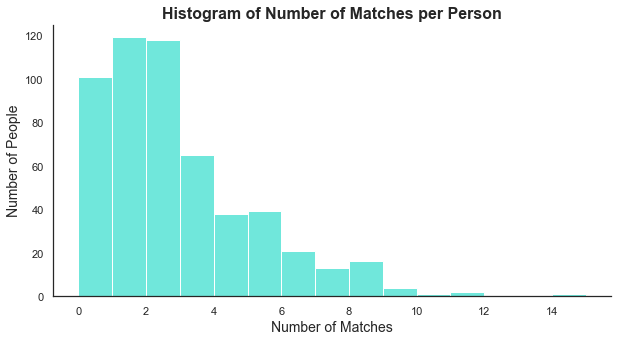

In [199]:
# Infer Person A's ID from each row, and use it to infer the number of participants and distribution of matches per participant

# Import the required visualisation packages
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate an ID for each person and count the number of IDs
dating_individual = dating.drop(columns=['age_o', 'd_age', 'samerace', 'pref_o_intelligence', 'pref_o_sincere', 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests', 'pref_o_attractive', 'interests_correlate', 'decision', 'decision_o', 'match', "race_o_'Asian/Pacific Islander/Asian-American'", "race_o_'Black/African American'", "race_o_'Latino/Hispanic American'", "race_o_European/Caucasian-American", 'race_o_Other'])
dating_individual['id'] = dating_individual.groupby(dating_individual.columns.tolist()).ngroup()
print("Number of individuals in dataset: ", dating_individual['id'].nunique()) # looks like there are 538 individuals in the cleaned data (may have been more in the original data)
print('  ')

# Append the ID column to a copy of the dating dataset
dating_extended = dating
dating_extended['id'] = dating_individual['id']
dating_extended.head()

# Calculate number of matches for each individual
to_plot = dating_extended.groupby('id')['match'].sum()

# Plot distribution of matches per person
sns.set_style('white')
sns.set_context('notebook')
fig, ax1 = plt.subplots(figsize=(10,5))
sns.despine(fig)
g = sns.histplot(data=to_plot, ax=ax1, bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], color='turquoise')
g.set_title('Histogram of Number of Matches per Person', fontweight='bold', fontsize=16)
g.set_xlabel('Number of Matches', fontsize=14)
g.set_ylabel('Number of People', fontsize=14)
plt.savefig('histogram.png', dpi=300)
plt.show()

The histogram shows that a significant proportion of people don't get any matches, reinforcing the problem we are facing. Potentially a machine learning model could help to pair up individuals on dates with other individuals that they are more likely to match with, which could reduce the proportion who leave the event without success.

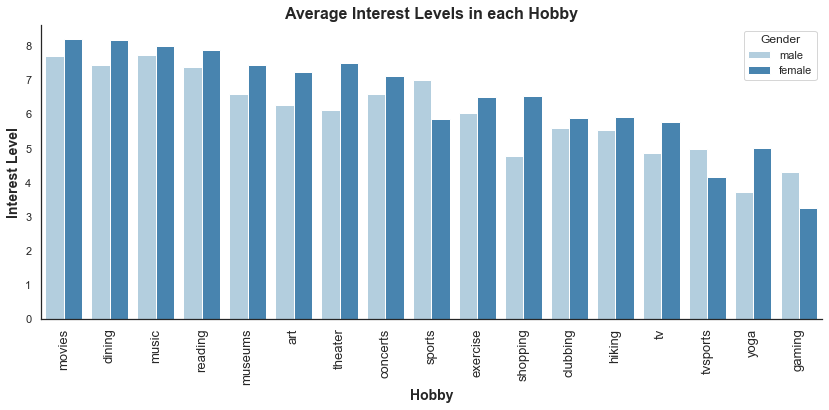

In [200]:
# Calculate average of each interest, to see which ones are common or less common

# Put the data together
interests_gender = ['gender', 'movies', 'dining', 'music', 'reading', 'museums', 'art', 'theater', 'concerts', 'sports', 'exercise', 'shopping', 'clubbing', 'hiking', 'tv', 'tvsports', 'yoga', 'gaming']
dating_int_gend = dating[interests_gender].groupby('gender').mean().transpose().rename_axis('interest').reset_index() # creates data table to plot
dating_int_gend = dating_int_gend.melt(id_vars='interest', value_vars=['male', 'female']).rename(columns=str.title) # manipulates data table into plottable format

# Plot the graph
fig, ax1 = plt.subplots(figsize=(14, 6))
plt.subplots_adjust(bottom=0.2)
g = sns.barplot(x='Interest', y='Value', hue='Gender', data=dating_int_gend, palette='Blues', ax=ax1)
g.set_title('Average Interest Levels in each Hobby', fontweight='bold', fontsize=16)
g.set_xlabel('Hobby', fontweight='bold', fontsize=14)
g.set_ylabel('Interest Level', fontweight='bold', fontsize=14)
sns.despine(fig)
plt.xticks(rotation=90, fontsize=13)
plt.savefig('hobbies.png', dpi=300)

Interests such as movies and music are much more common than others such as gaming. It may be that individuals with more common interests are more likely to get matches, as they are more likely to have something in common with their partner. However further analysis will be required before this can be confirmed.<br>
We can also see that certain hobbies such as yoga appeal more to women, whereas others such as gaming appeal more to men. Potentially these more divisive hobbies could have a negative impact on chance of a match.<br>
In general women rate their interest levels higher than men, exceeding them for 14 of the 17 hobbies stated. This could indicate that there is a slight bias towards hobbies popular with women, in which case we could include more diverse hobbies on our list when collecting data going forwards.

Age range:  18  -  55


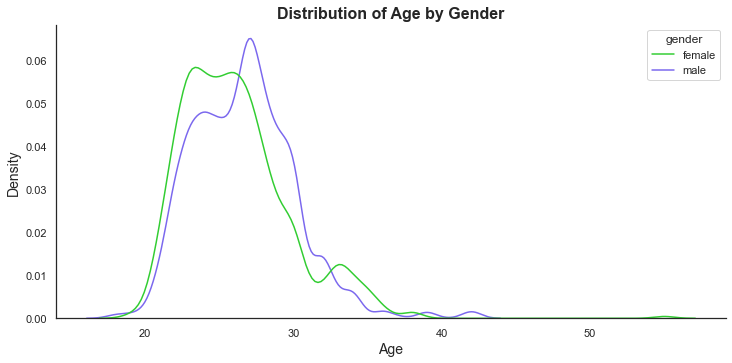

In [201]:
# Distribution plot of age and gender

# Print the range of ages in our dataset
print("Age range: ", dating['age'].min(), " - ", dating['age'].max())

# Plot the distribution of ages
sns.set_style('white')
fig, ax1 = plt.subplots(figsize=(12,6))
sns.despine(fig)
g = sns.kdeplot(data=dating, x='age', hue='gender', palette=['limegreen','mediumslateblue'], ax=ax1)
g.set_title('Distribution of Age by Gender', fontweight='bold', fontsize=16)
g.set_xlabel('Age', fontsize=14)
g.set_ylabel('Density', fontsize=14)
plt.subplots_adjust(bottom=0.2)
plt.savefig('age.png', dpi=500)
plt.show()

The above kde plot shows that most participants are in their twenties. On average the men are slightly older than the women, though not significantly. The age range is reasonably wide however, ranging from 18 to 55. If all participants go on dates with all other participants at the event, we could end up with some significant age differences, which could have a negative impact on the chance of a match. Therefore it could be worth creating some smaller 'sub-events' restricted to individuals within a particular age group.

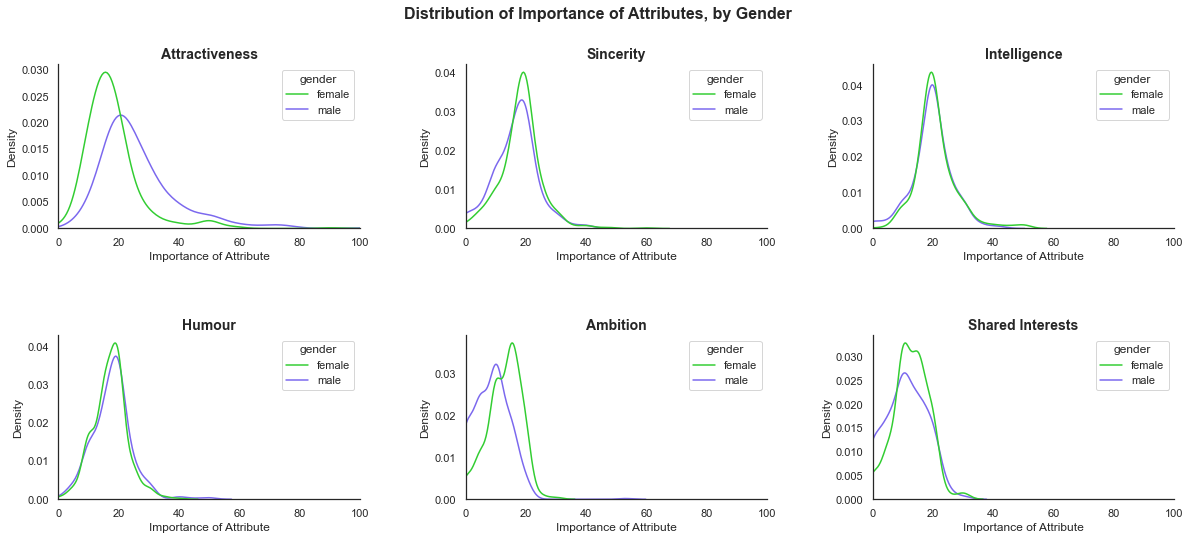

In [202]:
# Distribution plots of attribute importances by gender

# Create array of features to plot
importances = np.array([['attractive_important', 'sincere_important', 'intellicence_important'],
               ['funny_important', 'ambtition_important', 'shared_interests_important']])

# Create array of plot titles
titles = np.array([['Attractiveness', 'Sincerity', 'Intelligence'],
               ['Humour', 'Ambition', 'Shared Interests']])

# Set up the visualisation environment
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,8))
sns.despine()

# Generate each plot iteratively
for i in [0,1]:
    for j in [0,1,2]:
        g=sns.kdeplot(data=dating, x=importances[i,j], hue='gender', palette=['limegreen','mediumslateblue'], bw_adjust=2, ax=axs[i,j])
        g.set_title(titles[i,j], fontweight='bold', fontsize=14)
        g.set_xlabel('Importance of Attribute', fontsize=12)
        g.set_ylabel('Density', fontsize=12)
        g.set(xlim=(0, 100))
        
# Final touches
fig.suptitle('Distribution of Importance of Attributes, by Gender', fontweight='bold', fontsize=16)
plt.subplots_adjust(hspace = 0.65, wspace=0.35)
plt.savefig('importances.png')
plt.show()

From the distribution plots above we can see that all attributes have a similar average weighting; there is no particular attribute that is significantly more or less valued that the others. This suggests a participant who is well-rounded across the attributes might have a better chance of a match than a participant who shows much of one attribute but little of the others. However some features have a greater spread of weightings - for example the attractiveness weightings range up to 100%, suggesting this attribute is more divisive of opinion, whereas the shared interests weightings only go up to 40%. We can also see that men and women tend to value certain attributes differently - for example, men tend to value attractiveness more, whereas women tend to be more interested in ambition.

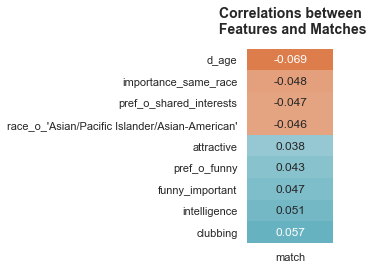

In [203]:
# Heatmap of strongest positive and negative correlations between features and matches

# Select the features with strongest correlations
correlations = pd.DataFrame(dating[['d_age', 'importance_same_race','pref_o_shared_interests',"race_o_'Asian/Pacific Islander/Asian-American'", 'attractive', 'pref_o_funny', 'funny_important', 'intelligence', 'clubbing','match']].corr()['match'].sort_values())
correlations = correlations.drop(labels=['match'], axis=0)

# Plot a heatmap of the correlations between said features and matches
fig, ax1 = plt.subplots(figsize=(8,4))
cmap = sns.diverging_palette(20, 220, as_cmap=True, s=100)
g = sns.heatmap(correlations, vmin=-0.1, vmax=0.1, annot=True, annot_kws={"fontsize":12}, cbar=False, cmap=cmap)
g.set_title('Correlations between\n Features and Matches', fontweight='bold', fontsize=14, pad=15)
plt.subplots_adjust(left=0.75, top=0.8)
fig.savefig('heatmap1.png')

From the heatmap of correlations we can see that interest in clubbing has the strongest positive correlation with matches, suggesting that the more interested in clubbing you are, the more likely you are to leave the event with a match. This is not something that is traditionally linked to dating success, but perhaps it's because people who like to go clubbing a lot are typically quite outgoing and sociable, which should theoretically increase their chances on a date. Self-rating of intelligence shows a similar positive correlation, possibly as those who consider themselves to be intelligent may have more interesting opinions to share on a date, or a broader range of topics of conversation.

Conversely, the age difference between the two participants has the strongest negative correlation with matches, which makes sense as people of a similar age are more likely to have similar interests, experiences and lifestyles. How important someone values being the same race as their partner also has a strong negative correlation, which is probably because they are more likely to write off a potential match simply because their partner is a different race to them.

Note that all of these correlations are individually quite weak, so would be very poor predictors of a match on their own. This is where machine learning can come in as it can take into account multiple variables at once. It's also worth noting that the correlation coefficient used in the diagram only takes into account linear correlations, so there may still be non-linear correlations in some of the other variables that haven't been picked up. Again, supervised learning algorithms such as random forests are better at picking up on this kind of relationship.

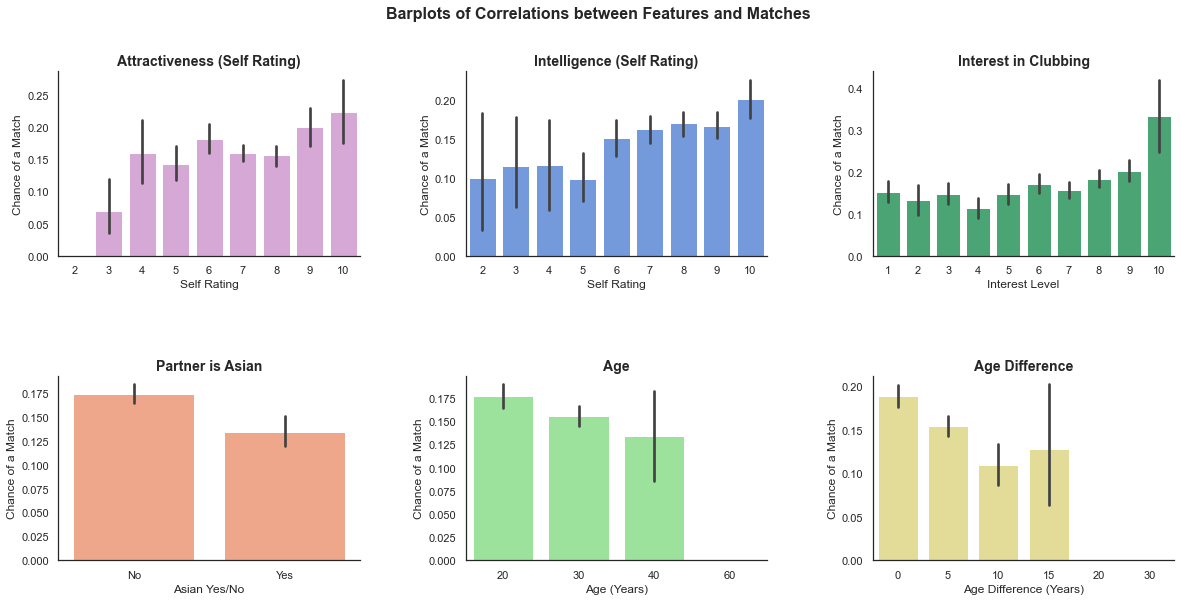

In [204]:
# Let's examine the correlation between features and matches in more detail for the interesting features.

# Bucket continuous variables:
def round_5(x, base=5):
    return base * round(x/base)
dating['age_bucket'] = round(dating['age'], -1)
dating['d_age_bucket'] = round_5(dating['d_age'])

# Create arrays of chart elements
features = np.array([['attractive', 'intelligence', 'clubbing'],
                             ["race_o_'Asian/Pacific Islander/Asian-American'", 'age_bucket', 'd_age_bucket']])
titles = np.array([['Attractiveness (Self Rating)', 'Intelligence (Self Rating)', 'Interest in Clubbing'],
               ['Partner is Asian', 'Age', 'Age Difference']])
colors = np.array([['plum', 'cornflowerblue', 'mediumseagreen'],
               ['lightsalmon', 'lightgreen', 'khaki']])
x_axes = np.array([['Self Rating', 'Self Rating', 'Interest Level'],
               ['Asian Yes/No', 'Age (Years)', 'Age Difference (Years)']])
x_labels = np.array([[[2,3,4,5,6,7,8,9,10], [2,3,4,5,6,7,8,9,10], [1,2,3,4,5,6,7,8,9,10]],
               [['No', 'Yes'], [20,30,40,60], [0,5,10,15,20,30]]], dtype=object)

# Set up the visualisation environment
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,9))
sns.despine()
    
# Generate each plot iteratively
for i in [0,1]:
    for j in [0,1,2]:
        g = sns.barplot(data=dating, x=features[i,j], y='match', color=colors[i,j], ax=axs[i,j])
        g.set_title(titles[i,j], fontweight='bold', fontsize=14)
        g.set_xlabel(x_axes[i,j], fontsize=12)
        g.set_ylabel('Chance of a Match', fontsize=12)
        axs[i,j].set_xticklabels(labels=x_labels[i,j])
        
# Final touches
fig.suptitle('Barplots of Correlations between Features and Matches', fontweight='bold', fontsize=16)
plt.subplots_adjust(hspace = 0.65, wspace=0.35)
plt.savefig('barplots.png', dpi=300)
plt.show()

In [205]:
print("Proportion of participants who are Asian: ", round(dating["race_o_'Asian/Pacific Islander/Asian-American'"].sum() / len(dating),2))
print("Chance of a match if you are Asian: ", round(dating[dating["race_o_'Asian/Pacific Islander/Asian-American'"]==1]['match'].mean(),2))
print("Chance of a match if you are not Asian: ", round(dating[dating["race_o_'Asian/Pacific Islander/Asian-American'"]==0]['match'].mean(),2))

Proportion of participants who are Asian:  0.24
Chance of a match if you are Asian:  0.13
Chance of a match if you are not Asian:  0.17


The above plots show the average chance of a match across six different features, with confidence intervals overlayed. The features were chosen for their strong visual correlations.

As expected from the heatmap of correlations, interest in clubbing, attractiveness and intelligence self-rating both show an upward trend, indicating a positive correlation with the chance of a match. Conversely age and age difference show a downward trend, reinforcing the negative correlations shown in the heatmap. For the clubbing and age difference plots in particular, we can see that some of the confidence intervals do not overlap, which shows that these features have a statistically significant impact on an individual's chance of a match.

Surprisingly, whether the individual's partner is Asian, Pacific Islander or Asian-American (referred to as Asian from now on) also has a statistically significant impact on the chance of a match, with Asian partners being only 13% likely to find a match compared to 17% for non-Asian partners. It's not immediately obvious why this might be, but it could be associated with cultural differences, or perhaps that people of Asian origin are more or less likely to be interested in certain hobbies that could affect their chance of a match.

In [206]:
# Compare the average success rate for those who rate clubbing as 10 out of 10 versus everyone else
clubbing_lovers = dating[dating['clubbing']==10]['match']
everyone_else = dating[dating['clubbing']!=10]['match']
print(round(clubbing_lovers.mean(),2)*100,"%")
print(round(everyone_else.mean(),2)*100,"%")

33.0 %
16.0 %


In [207]:
# Perfom a hypothesis test evaluating whether the match rate differs for those who rate clubbing as 10 out of 10
from scipy import stats
stats.ttest_ind(clubbing_lovers, everyone_else)

Ttest_indResult(statistic=4.712272116694601, pvalue=2.4907617956136554e-06)

We can see from above that those who rated their interest in clubbing as 10/10 have on average a 33% chance of a match, compared to 16% for everyone else. These chances are only estimates based on the data available; however a two-sample hypothesis test confirms that the average chance of a match is highly likely (>99.99%) to be different for the two groups.

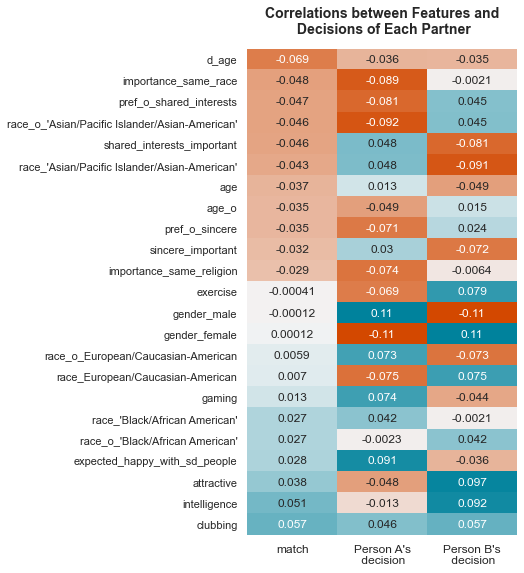

In [208]:
# Heatmap of most interesting correlations between features and individual decisions, rather than matches

# Select features of interest
correlations_augmented = pd.DataFrame(dating[['d_age', 'age', 'age_o',    'gender_male', 'gender_female','expected_happy_with_sd_people', 'attractive', 'intelligence', 'pref_o_sincere', 'sincere_important', 'pref_o_shared_interests', 'shared_interests_important','importance_same_religion','importance_same_race',"race_o_'Asian/Pacific Islander/Asian-American'","race_'Asian/Pacific Islander/Asian-American'", "race_European/Caucasian-American", "race_o_European/Caucasian-American","race_'Black/African American'", "race_o_'Black/African American'",'clubbing', 'exercise', 'gaming', 'match', 'decision', 'decision_o']].corr()[['match', 'decision', 'decision_o']].sort_values(by=['match', 'decision', 'decision_o']))
correlations_augmented = correlations_augmented.drop(labels=['match', 'decision', 'decision_o'], axis=0)

# Generate the plot
fig, ax = plt.subplots(figsize=(25,10))
g = sns.heatmap(correlations_augmented, vmin=-0.1, vmax=0.1, annot=True, annot_kws={"fontsize":12}, cbar=False, cmap=cmap, ax=ax)
g.set_title('Correlations between Features and\n Decisions of Each Partner', fontweight='bold', fontsize=14, pad=15)
ax.set_xticklabels(labels=['match', "Person A's\n decision", "Person B's\n decision"], fontsize=12)
plt.subplots_adjust(left=0.75, top=0.8)
fig.savefig('heatmap2.png', dpi=300)

The above plot shows the heatmap of correlations with matches that we saw before. However we have also added in correlations with Person A's decision (i.e. whether or not they want to see their partner again), and correlations with Person B's decision in the rightmost column, in order to break down our analysis further. 

We can see that certain features such as Person A's interest in clubbing appear to have a positive impact on both partner's decisions, and other features such as age difference have a negative impact on both decisions. However there are certain features that will raise one partner's chance of saying yes while lowering the other partner's chance. The strongest such feature is gender, showing that male participants are more likely to say yes to their partner than female participants. Another such feature is someone's self-rating of attractiveness; if they rate themselves highly, they are more likely to be said yes to by their partner, but somewhat less likely to say yes back. Interest in exercise has a similar effect.

However the most common type of feature that appears to divide the partner's decisions appears to be race. For example, Asian participants are more likely to say yes to their partner but less likely to be said yes to. For white participants it is the opposite story - they appear to be more popular but also more picky. Black participants are typically more likely to say yes to their partner, but there is not much impact on their partner's decision. For Latinos / Hispanic Americans, there appears to be very little impact on either partners decision.

The reasons behind these racial variances are unclear. One might hypothesise that people prefer to date those with the same race as them, which is why ethnic minorities have a lower chance of a match due to there being fewer of them. However 'samerace' is already a feature, and while it has a positive correlation with each partner's decision, the correlation is not as strong as that which is specific to the race of the participant. Therefore further research into these trends would be recommended in order to establish the reasons behind them.

### Machine Learning

To prepare the data for machine learning, we will scale it before splitting it into a training and test set. We will fix the random state for reproducibility, shuffle the data given it was originally ordered by individual, and stratify the labels in order to ensure the test and training data reflects the original dataset. Subsequently we will apply synthetic minority oversampling to the training set to mitigate the imbalance between matches and non-matches.

In [209]:
# Drop gender object column and other created columns
dating = dating.drop(columns=['gender', 'age_bucket', 'd_age_bucket'])
print(dating.columns)

Index(['age', 'age_o', 'd_age', 'samerace', 'importance_same_race',
       'importance_same_religion', 'pref_o_attractive', 'pref_o_sincere',
       'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious',
       'pref_o_shared_interests', 'attractive_important', 'sincere_important',
       'intellicence_important', 'funny_important', 'ambtition_important',
       'shared_interests_important', 'attractive', 'sincere', 'intelligence',
       'funny', 'ambition', 'sports', 'tvsports', 'exercise', 'dining',
       'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv',
       'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga',
       'interests_correlate', 'expected_happy_with_sd_people', 'decision',
       'decision_o', 'match', 'gender_female', 'gender_male',
       'race_'Asian/Pacific Islander/Asian-American'',
       'race_'Black/African American'', 'race_'Latino/Hispanic American'',
       'race_European/Caucasian-American', 'race_Other',
       'race_o_'Asian

In [210]:
# Split into features (X) and target variable (y)
X = dating.drop(['match','decision', 'decision_o'], axis=1)
y = dating[['match']]
X_orig = X # saving for later use

In [211]:
# Scale the data
from sklearn.preprocessing import scale
X = scale(X)
X

array([[-1.50861322,  0.17596394,  0.75870647, ...,  0.87322342,
        -0.26044681, -1.70140202],
       [-1.50861322, -1.2299335 , -0.86922829, ...,  0.87322342,
        -0.26044681, -1.70140202],
       [-1.50861322, -1.2299335 , -0.86922829, ..., -1.1451823 ,
        -0.26044681, -1.70140202],
       ...,
       [-0.38508145, -0.66757453, -0.86922829, ..., -1.1451823 ,
         3.83955564, -0.48539139],
       [-0.38508145, -1.2299335 , -0.21805439, ..., -1.1451823 ,
        -0.26044681, -0.48539139],
       [-0.38508145, -1.2299335 , -0.21805439, ..., -1.1451823 ,
        -0.26044681, -0.48539139]])

In [212]:
# Split data into training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.1, 
                                                   random_state=21, 
                                                   stratify=y, 
                                                   shuffle = True)

In [213]:
# Synthetic Minority Oversampling Technique
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
X_train, y_train = sm.fit_resample(X_train, y_train)

When evaluating the performance of machine learning models, accuracy is a poor choice for this problem. This is because the data is imbalanced, so even if a model predicted "no match" for every couple, it would achieve an accuracy score of 84%. Instead we can use a confusion matrix to split the results by actual outcome (match / no match) and predicted outcome (match / no match). False positives are a problem for us because they mean participants would be predicted matches that turn out to be wrong, resulting in disappointment. However false negatives are also an issue because they would result in missing potential matches between participants. Therefore it makes sense to use a metric such as the F1 score, which takes into account both false positives and false negatives by computing a weighted average of precision and recall.

In [214]:
# Evaluate cross-validation scores for a variety of different models

# Import the required packages and functions
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

# Define the models to fit
knn = KNeighborsClassifier(n_neighbors=30) 
logreg = LogisticRegression()
dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=0.4, random_state=1)
rt = RandomForestClassifier(n_estimators=50, min_samples_leaf=0.01, random_state=1)
gbt = GradientBoostingClassifier(n_estimators=60, max_depth=1, random_state=15)
vc = VotingClassifier(estimators=[('K Nearest Neighbours', knn), ('Logistic Regression', logreg), ('Random Forest', rt), ('Gradient Boosting', gbt)], voting='soft')

# Evaluate cross-validation scores for each model
models = [knn, logreg, dt, rt, gbt, vc]
y_pred = []
for model in models:
    print("Model: ", model)
    print("F1 (cross-val): ", round(cross_val_score(model, X_train, y_train.values.ravel(), scoring='f1').mean(),2))   
    print(' ')

Model:  KNeighborsClassifier(n_neighbors=30)
F1 (cross-val):  0.73
 
Model:  LogisticRegression()
F1 (cross-val):  0.6
 
Model:  DecisionTreeClassifier(max_depth=3, min_samples_leaf=0.4, random_state=1)
F1 (cross-val):  0.55
 
Model:  RandomForestClassifier(min_samples_leaf=0.01, n_estimators=50, random_state=1)
F1 (cross-val):  0.79
 
Model:  GradientBoostingClassifier(max_depth=1, n_estimators=60, random_state=15)
F1 (cross-val):  0.71
 
Model:  VotingClassifier(estimators=[('K Nearest Neighbours',
                              KNeighborsClassifier(n_neighbors=30)),
                             ('Logistic Regression', LogisticRegression()),
                             ('Random Forest',
                              RandomForestClassifier(min_samples_leaf=0.01,
                                                     n_estimators=50,
                                                     random_state=1)),
                             ('Gradient Boosting',
                              Grad

A number of different models were tried out to start with and evaluated using cross validation on the F1 score. The Random Forest Classifier came out on top. This is unsurprising for this type of problem, because tree-based models are well suited to combinations of categorical and numerical features, and can also capture non-linear relationships between features and labels. Next we will find the best parameters for our model using hyperparameter tuning.

In [215]:
# Identifying the best parameters using hyperparameter tuning

from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': np.arange(10, 80, 10),
              'min_samples_leaf': np.arange(0.01, 0.2, 0.02)}
RF = RandomForestClassifier(random_state=1)
RF_Grid_CV = GridSearchCV(RF, param_grid, cv=5, scoring='f1')
RF_Grid_CV.fit(X_train, y_train.values.ravel())

print("Best parameters: ", RF_Grid_CV.best_params_)
print("Best CV score: ", RF_Grid_CV.best_score_)

Best parameters:  {'min_samples_leaf': 0.01, 'n_estimators': 70}
Best CV score:  0.7896825590395379


Hyperparameter tuning has identified an optimal Random Forest Classifier with 70 estimators and each leaf containing at least 1% of the training data.

In [216]:
# Calculate the training score
My_RF = RandomForestClassifier(n_estimators=70, min_samples_leaf=0.01, random_state=2)
My_RF.fit(X_train, y_train.values.ravel())
y_pred_train = My_RF.predict(X_train)
print(f1_score(y_train, y_pred_train))

0.8540278619018776


In [217]:
# Calculate the test score
y_pred = My_RF.predict(X_test)
print(f1_score(y_test, y_pred))

0.2520325203252033


In [218]:
# Further evaluation of our model using other metrics

from sklearn.metrics import confusion_matrix, accuracy_score
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy:  0.771712158808933
F1:  0.2520325203252033
Recall:  0.23484848484848486
Precision:  0.2719298245614035
[[591  83]
 [101  31]]


Even when using a suitable model and optimal parameters, the resulting predictor produces poor results, with an F1 score of only 0.25. This is likely a combination of romantic matches being notoriously hard to predict, and also the limited nature of the data we are using. In particular we have very little information about Person B. In order to improve the model I would recommend collecting further data - Person B should be asked the same questions as Person A, and in addition a number of extra questions could be included, such as physical attributes/preferences, education levels, values, political leanings and additional interests such as animals or travelling.

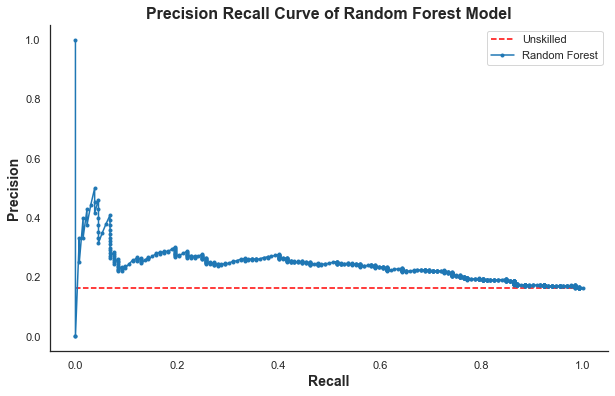

In [219]:
# Plot the Precision Recall curve

# Assemble the data
from sklearn.metrics import precision_recall_curve
y_pred_prob = My_RF.predict_proba(X_test)[:,1] 
RF_precision, RF_recall, _ = precision_recall_curve(y_test, y_pred_prob)

# Generate the plot
fig, axs = plt.subplots(figsize=(10,6))
sns.despine()
unskilled = len(y_test[y_test['match']==True]) / len(y_test)
plt.plot([0,1], [unskilled, unskilled], linestyle='--', label='Unskilled', color='red')
plt.plot(RF_recall, RF_precision, marker='.', label='Random Forest')
axs.set_title('Precision Recall Curve of Random Forest Model', fontweight='bold', fontsize=16)
axs.set_xlabel('Recall', fontweight='bold', fontsize=14)
axs.set_ylabel('Precision', fontweight='bold', fontsize=14)
plt.legend()
fig.savefig('precision_recall.png')
plt.show()

The precision recall curve further demonstrates that the model is relatively weak, as the plot of the Random Forest Classifier does not get near to (1,1). However it does show that it clearly outperforms an unskilled model, shown by the dashed red line.

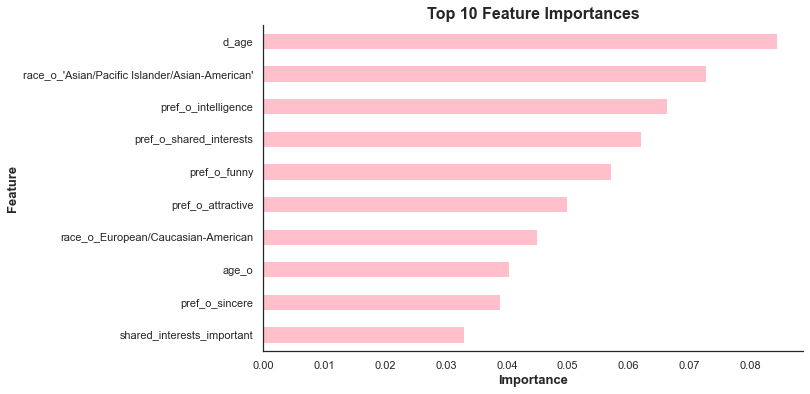

In [220]:
# Visualise top 10 most important features

# Assemble the data
importances_RF = pd.Series(My_RF.feature_importances_, index = X_orig.columns).sort_values()
importances_RF_top10 = importances_RF[-10:]

# Generate the plot
fig, axs = plt.subplots(figsize=(15,6))
sns.despine()
g = importances_RF_top10.plot(kind='barh', color='pink')
g.set_title('Top 10 Feature Importances', fontweight='bold', fontsize=16)
g.set_xlabel('Importance', fontweight='bold', fontsize=13)
g.set_ylabel('Feature', fontweight='bold', fontsize=13)
plt.subplots_adjust(left=0.4)
fig.savefig('feature_importances.png')
plt.show()

As expected, the features that prove most important in predicting matches roughly correspond to those features with a strong linear correlation to matches, which we identified in the Exploratory Data Analysis section. For example we can see age difference is the most important feature, which is in line with our heatmap showing it to have the strongest correlation to matches of all the variables. However some other variables with strong linear correlations are missing. This could be because there are relationships between the features themselves; for example, if two features are highly correlated the model could just use one of them for its predictions, effectively discarding the other feature as it doesn't add any extra value. 

Another point of interest is that most of the top 10 important features relate to Person B. This is possibly because there is very little data on Person B compared to Person A, and so any data that the model can use on Person B will be weighted much more strongly.

Finally there are some variables on this diagram that didn't show any linear correlation in our earlier analysis, such as interest in TV sports. This is likely because there is a relationship between interest in TV sports and chance of a match, but it is non-linear, so didn't get identified by the Pearson correlation coefficient. As mentioned previously, the ability to identify non-linear relationships between features and values is one of the advantages of tree-based models. A plot of chance of a match by interest in TV sports is shown below to demonstrate this. Note that there is no obvious linear trend, but many of the confidence intervals do not overlap, suggesting that the difference in match likelihood by interest in sport is statistically significant.

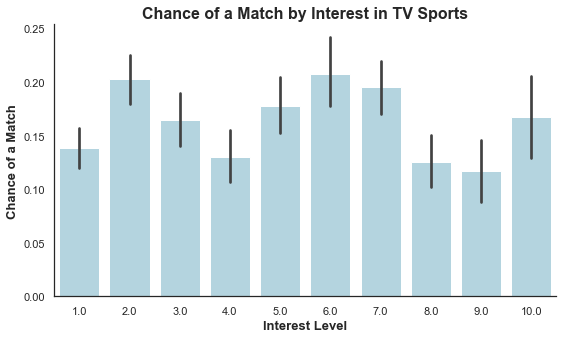

In [221]:
# Demonstrate that tvsports is correlated to matches, just not linearly correlated

# Set up the visualisation environment
fig, axs = plt.subplots(figsize=(9,5))
sns.despine()
    
# Generate the plot
g = sns.barplot(data=dating, x='tvsports', y='match', ax=axs, color='lightblue')
g.set_title('Chance of a Match by Interest in TV Sports', fontweight='bold', fontsize=16)
g.set_xlabel('Interest Level', fontweight='bold', fontsize=13)
g.set_ylabel('Chance of a Match', fontweight='bold', fontsize=13)
        
# Final touches
plt.subplots_adjust(hspace = 0.3)
fig.savefig('tv_sports.png')
plt.show()

### Conclusions and Recommendations

**Conclusions**<br>

The aim of this project was to investigate which factors affect the likelihood of a match, and to use supervised machine learning techniques to develop a predictive model that aims to predict whether or not two participants will be a match.

Cleaning the data highlighted several data quality issues. A number of missing values were present in the data, which had to be removed. There were some anomalous values such as 13 when the answer should have been on a scale from 0-10. There were also a number of spelling mistakes in the feature names which made them difficult to refer to in the code, as well as a few feature names that didn't have a description. Additionally many of the features were redundant for the purposes of this analysis, typically because they weren't possible to collect in advance of the date. 

Exploratory data analysis helped to identify key features that affect a couple's chance of matching, by calculating and visualising the linear correlation between the features and the likelihood of a match. We found that certain features such as interest in clubbing and intelligence self-rating had a positive impact on the chance of a match, whereas features such as age difference had a negative impact. In some cases the difference in average chance of a match across responses to a particular question was shown to be statistically significant. Further analysis highlighted the complexity of the problem, by demonstrating that some variables would increase the chance of Person A saying yes to their partner, but would decrease the chance of Person B saying yes. The most common such variables are related to race. 

To predict the matches, a random forest model was fit to the data and optimised using hyperparameter tuning. The F1 score was used to evaluate the model, given it works well on imbalanced data and takes into account both false positives as well as false negatives. A plot of the precision recall curve of the model showed that it outperformed an unskilled model, and therefore is a better predictor of matches than the current method where participants are simply paired up with everyone else at the event. Therefore if we incorporate this predictive model into our events going forwards, we could selectively pair up individuals based on their likely matches, increasing match likelihood and customer satisfaction. However it’s worth noting that the resulting model achieved an F1 score of 0.25 which is fairly weak. This is likely because there is very little information about each participant in the dataset; especially Person B. 

**Recommendations**<br>

Steps should be taken to make the dataset cleaner for future analysis. When collecting the data electronically, automatically preventing the questionnaire from submitting until all answers are filled in would be advised to prevent missing values. The values that can be entered in response to each question should be restricted, for example via a drop-down list, to eliminate outliers. Spelling mistakes in the feature names should be fixed to aid future analysis. Questions that don’t add any value (e.g. those that can only be asked after the date) could also be dropped for this specific prediction analysis.

To improve the predictive power of the machine learning model, increasing the data collected would be advised. More data should be collected in advance of the date on Person B to match the information collected on Person A, and additionally extra data could be collected, such as physical attributes/preferences, education levels, values, political leanings and additional interests. This is likely to give a more complete picture of each individual and result in a stronger predictive model.

To make use of the predictions made by the random forest classifier, data could be collected from a large number of individuals, matches could be predicted using the model, and then smaller speed dating events could be organised where the participants are grouped according to their likely matches. This would ensure that participants get to see their most likely matches and spend less time talking to people that they don’t feel a connection with. In turn this would lead to more participants leaving with a match, boosting the business’s reputation and thereby attracting new customers and revenue.